# Mohammad Amin Nazerzadeh: mohammad.nazerzadeh@studio.unibo.it
# Davide Baldelli: davide.baldelli4@studio.unibo.it
# Mohammad Reza Ghasemi Madani: mohammadreza.ghasemi@studio.unibo.it 

#Generator Component

In this notebook we are going to build the Answer Generator component fro our solution to HotPotQA.

It consists of a small-T5 model trained first on SQuAD and fine-tuned on HotPotQA. The intuition behind this choice is well explained in ([Li et al., 2022](https://arxiv.org/abs/2205.11729)): 
> *We assume that
training on the single-hop dataset could initialize
the model with better parameters and make it easier
for the model to answer multi-hop questions. In
addition, the process of learning from easy to hard
is consistent with the widely accepted concept that
there supposed to be a gradual progression of skill
acquisition.*

## Install dependencies

In [ ]:
!pip install --quiet transformers datasets sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 4.5 MB/s eta 0:00:00


## Set Random Seed

In [ ]:
import numpy as np
import random
import torch
import transformers

def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    transformers.set_seed(seed)
    
set_reproducibility(42)

## Logging in HF

In [ ]:
from huggingface_hub import notebook_login, create_repo

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Setting device

Utilites to check both RAM and GPU memory availability

In [ ]:
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  2 09:48:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import psutil
import pandas as pd
def get_ram_info():
    infos = []
    columns = ["Total (Gb)", "Available (Gb)", "Available (%)", "Used (Gb)"]
    ram = psutil.virtual_memory()
    infos.append(round(ram[0] / 10**9, 2))
    infos.append(round(ram[1] / 10**9, 2))
    infos.append(round(ram[3] / 10**9, 2))
    infos.append(round(ram[4] / 10**9, 2))
    display(pd.DataFrame([infos], columns=columns , index = ["Ram"]))

In [ ]:
get_ram_info()

,Total (Gb),Available (Gb),Available (%),Used (Gb)
Ram,13.62,12.3,1.02,8.55


## Downloading HotPotQA

In [ ]:
from datasets import load_dataset

hpqa = load_dataset("hotpot_qa", "distractor")

Generating train split:   0%|          | 0/90447 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7405 [00:00<?, ? examples/s]

Dataset hotpot_qa downloaded and prepared to /root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Let's have a look to the structure of the dataset

In [ ]:
hpqa

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 90447
    })
    validation: Dataset({
        features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
        num_rows: 7405
    })
})

As it comes without a test set, we are going to compute a train - validation split on the provided train set, and use the validation set as test.

## Explore HotPotQA

Let's see how a sample looks like

In [ ]:
import numpy as np 
from pprint import pprint

idx = np.random.randint(len(hpqa["validation"]))
pprint(hpqa["train"][idx])

{'answer': 'research and development',
 'context': {'sentences': [['Sidney George Reilly MC ( \u20091873 – \u20091925 '
                            '), commonly known as the "Ace of Spies", was a '
                            'secret agent of the British Secret Service '
                            'Bureau, the precursor to the modern British '
                            'Secret Intelligence Service (MI6/SIS).',
                            ' He is alleged to have spied for at least four '
                            'different powers.'],
                           ['Abraham W. Bolden (born January 19, 1935) is an '
                            'American former United States Secret Service '
                            'agent - the first African-American Secret Service '
                            'agent assigned to the Presidential Protective '
                            'Division, appointed by John F. Kennedy in 1961.',
                            ' Bolden was fired from the Secret 

Let's print out some statistics about the dataset

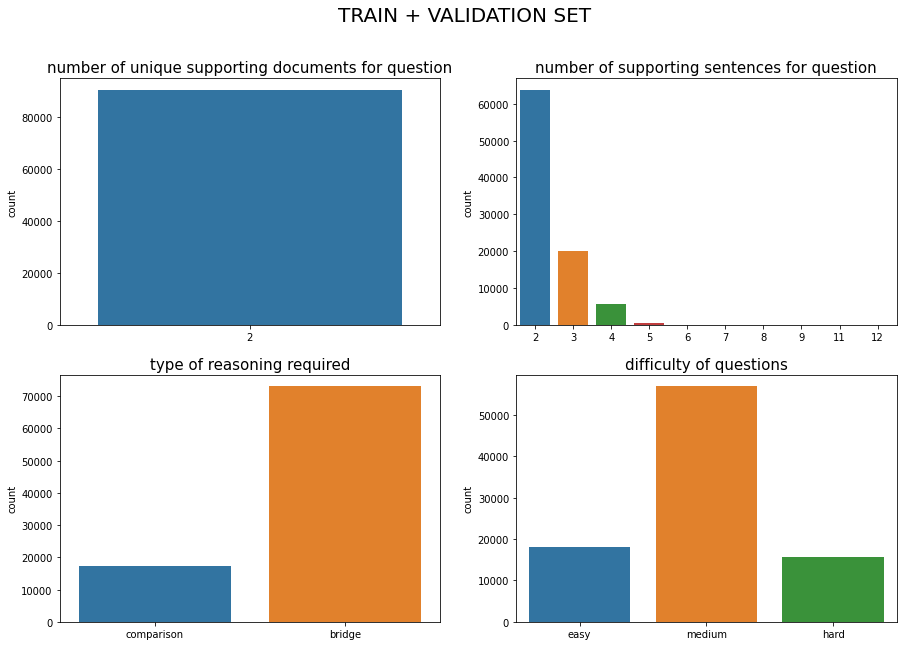

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset


fig, axs = plt.subplots(2,2,figsize = (15,10))

fig.suptitle("TRAIN + VALIDATION SET", size = 20)

sns.countplot(x = [len(np.unique(x['title'])) for x in hpqa['train']['supporting_facts']], ax = axs[0, 0])
axs[0,0].set_title("number of unique supporting documents for question", size = 15)

sns.countplot(x = [len(x['sent_id']) for x in hpqa['train']['supporting_facts']], ax = axs[0, 1])
axs[0,1].set_title("number of supporting sentences for question", size = 15)

sns.countplot(x = hpqa['train']['type'], ax = axs[1, 0])
axs[1,0].set_title("type of reasoning required", size = 15)

sns.countplot(x = hpqa['train']['level'], order = ["easy", "medium", "hard"], ax = axs[1, 1])
axs[1,1].set_title("difficulty of questions", size = 15)
plt.show()

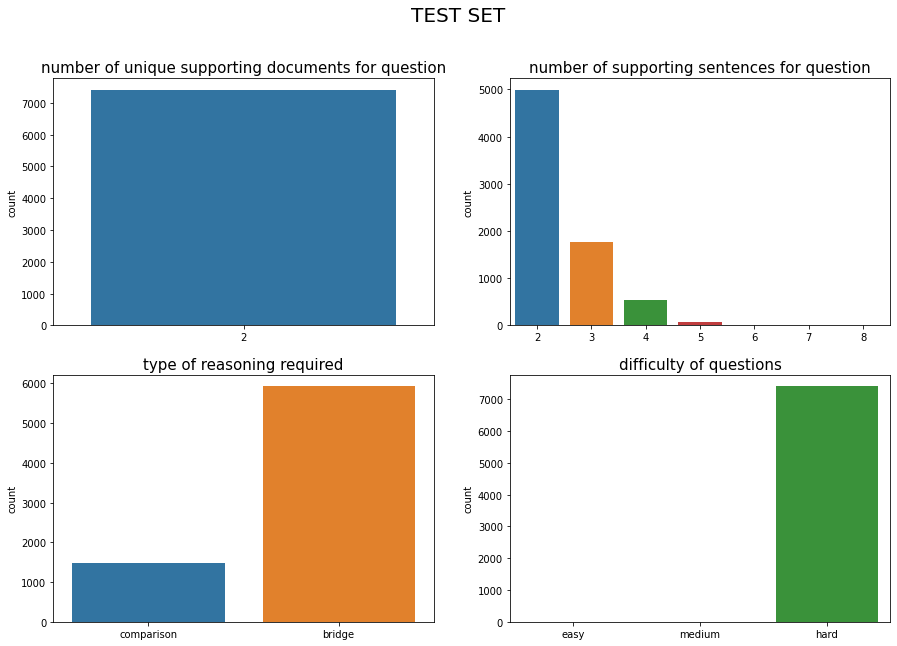

In [ ]:
fig, axs = plt.subplots(2,2,figsize = (15,10))

fig.suptitle("TEST SET", size = 20)

sns.countplot(x = [len(np.unique(x['title'])) for x in hpqa['validation']['supporting_facts']], ax = axs[0, 0])
axs[0,0].set_title("number of unique supporting documents for question", size = 15)

sns.countplot(x = [len(x['sent_id']) for x in hpqa['validation']['supporting_facts']], ax = axs[0, 1])
axs[0,1].set_title("number of supporting sentences for question", size = 15)

sns.countplot(x = hpqa['validation']['type'], ax = axs[1, 0])
axs[1,0].set_title("type of reasoning required", size = 15)

sns.countplot(x = hpqa['validation']['level'], order = ["easy", "medium", "hard"], ax = axs[1, 1])
axs[1,1].set_title("difficulty of questions", size = 15)
plt.show()

All the questions are "hard" in the test set. Rather than this, all the other statistics seem to be coherent between test and train.

## Import Model and Tokenizer - T5-small

I am going to use a Hugging Face small-T5 model. The input should take this form: 
> "question: {*question*} context: {*context*}" 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small"

base_tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
print(f"Number of parameters: {base_model.num_parameters()}")

Number of parameters: 60506624


Let's see how it works in a sample question. 

In [ ]:
import torch

question, context = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input = f"question: {question} context: {context}"

encoding = base_tokenizer(input, return_tensors='pt').to(device)

output = base_model.generate(**encoding, 
                        do_sample = True, 
                        top_k = 10,
                        top_p=0.9, 
                        max_length = 128) 

decoded_output = base_tokenizer.decode(output[0], skip_special_tokens = True) 
print(f"""
Question: {question}
Context: {context}
T5 answer: {decoded_output}""")


Question: Who was Jim Henson?
Context: Jim Henson was a nice puppet
T5 answer: puppet


## Import Model and Tokenizer - T5-small fine tuned on Squad

I am going to use a Hugging Face small-T5 model fine-tuned on Squad. The input should take this form: 
> "question: {*question*} context: {*context*}" 

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "mrm8488/t5-small-finetuned-squadv2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [ ]:
print(f"Number of parameters: {model.num_parameters()}")

Number of parameters: 60506624


Let's see how it works in a sample question. 

In [ ]:
import torch

question, context = "Who was Jim Henson?", "Jim Henson was a nice puppet"
input = f"question: {question} context: {context}"

encoding = tokenizer(input, return_tensors='pt').to(device)

output = model.generate(**encoding, 
                        do_sample = True, 
                        top_k = 10,
                        top_p=0.9, 
                        max_length = 128) 

decoded_output = tokenizer.decode(output[0], skip_special_tokens = True) 
print(f"""
Question: {question}
Context: {context}
T5 answer: {decoded_output}""")


Question: Who was Jim Henson?
Context: Jim Henson was a nice puppet
T5 answer: nice puppet


## Eval function

Eval function taken directly by the [Evaluation script](https://raw.githubusercontent.com/hotpotqa/hotpot/master/hotpot_evaluate_v1.py) of HotPotQA. 

In [ ]:
import re
import string 
from collections import Counter


def normalize_answer(s):

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    normalized_prediction = normalize_answer(prediction)
    normalized_ground_truth = normalize_answer(ground_truth)

    ZERO_METRIC = (0, 0, 0)

    if normalized_prediction in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC
    if normalized_ground_truth in ['yes', 'no', 'noanswer'] and normalized_prediction != normalized_ground_truth:
        return ZERO_METRIC

    prediction_tokens = normalized_prediction.split()
    ground_truth_tokens = normalized_ground_truth.split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return ZERO_METRIC
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1, precision, recall

def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))

# Prediction ids, label ids -> F1
# To use duruing training loop
def compute_metrics(pred_ids, labels_ids): 
    pred_tokens = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_tokens = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    f1s = []

    for pred, gold in zip(label_tokens, pred_tokens):
      f1s.append(f1_score(pred, gold)[0])

    return np.mean(f1s)  

# Prediction ids, label ids -> F1, EM
# To use in final evaluations
def compute_metrics_eval(pred_ids, labels_ids): 
    pred_tokens = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_tokens = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    f1s = []
    ems = []
    for pred, gold in zip(label_tokens, pred_tokens):
      f1s.append(f1_score(pred, gold)[0])
      ems.append(exact_match_score(pred, gold))
    return np.mean(f1s), np.mean(ems)

## Preprocessing

First of all I am going to create `pandas.DataFrame` version of the datasets with the following columns: 
> id, question, context, answer, level, type

Where the contexts will be composed of the supporting facts concatenated. 

In [ ]:
import pandas as pd 
from tqdm import tqdm 

columns = ["id", "question", "context", "answer", "level", "type"]

#######################################
###### TRAIN + VAL PREPROCESSING ######
#######################################


comp_list = []

err_train_ids = []
i = 0
for row in tqdm(hpqa["train"]):
    
    question = row["question"]
    answer = row["answer"]
    level = row["level"]
    type_question = row["type"]
    id = row["id"]

    sent_ids = row["supporting_facts"]["sent_id"] 
    gold_titles = row["supporting_facts"]["title"]
    titles = row["context"]["title"]
    gold_ids = [titles.index(gold_title) for gold_title in gold_titles]

    try: 
      gold_sentences = [row["context"]["sentences"][gold_id][sent_id] for gold_id, sent_id in zip(gold_ids, sent_ids)]
      context = " ".join(gold_sentences)
    except IndexError: 
      err_train_ids.append(i)
      i+=1
      continue


    i+=1
    comp_list.append([id, question, context, answer, level, type_question])

train_df = pd.DataFrame(comp_list, columns = columns)

################################
###### TEST PREPROCESSING ######
################################

comp_list = []

err_val_ids = []
i=0
for row in tqdm(hpqa["validation"]):
    
    question = row["question"]
    answer = row["answer"]
    level = row["level"]
    type_question = row["type"]
    id = row["id"]


    sent_ids = row["supporting_facts"]["sent_id"] 
    gold_titles = row["supporting_facts"]["title"]
    titles = row["context"]["title"]
    gold_ids = [titles.index(gold_title) for gold_title in gold_titles]

    try: 
      gold_sentences = [row["context"]["sentences"][gold_id][sent_id] for gold_id, sent_id in zip(gold_ids, sent_ids)]
      context = " ".join(gold_sentences)
    except IndexError: 
      err_val_ids.append(i)
      i+=1
      continue

    i+=1
    comp_list.append([id, question, context, answer, level, type_question])

test_df = pd.DataFrame(comp_list, columns = columns)

100%|██████████| 7405/7405 [00:01<00:00, 5052.68it/s]


We have found that there are some bad indexed samples. We have collected the indexes in the lists `err_train_ids` and `err_val_ids`. For example, in the following sample, one of the supporiting facts should be the fourth sentence (index 3) of the paragraph "Jodie Witthaker", that only has 3 sentences. 

We have discarded those samples. 



In [ ]:
hpqa["train"][err_train_ids[-1]]

{'id': '5a8a317455429930ff3c0cef',
 'question': "This British comedy-drama film starred Peter O'Toole and an English actress praised for her role as a grieving mother in what film?",
 'answer': 'Broadchurch',
 'type': 'bridge',
 'level': 'medium',
 'supporting_facts': {'title': ['Venus (film)',
   'Jodie Whittaker',
   'Jodie Whittaker',
   'Jodie Whittaker'],
  'sent_id': [0, 0, 2, 3]},
 'context': {'title': ['Venus (film)',
   'B.S. I Love You',
   'East Is East (1999 film)',
   'Jessica Brown Findlay',
   'The Long and the Short and the Tall (play)',
   'Bring Back the Dead',
   'Jodie Whittaker',
   'Faust (1960 film)',
   'Roberta Tovey',
   'Beverly Hills Brats'],
  'sentences': [["Venus is a 2006 British comedy-drama film starring Peter O'Toole, Leslie Phillips, Vanessa Redgrave and Jodie Whittaker.",
    ' It is directed by Roger Michell and written by Hanif Kureishi.'],
   ['B.S. I Love You is an American comedy-drama film from 1971.',
    ' It was directed and written by Stev

In [ ]:
print(f"There are {len(err_train_ids)} bad indexed samples in the train + val dataset.")
print(f"There are  {len(err_val_ids)} bad indexed samples in the test dataset.")

There are 22 bad indexed samples in the train + val dataset.
There are  1 bad indexed samples in the test dataset.


Computing the train - validation split

In [ ]:
from sklearn.model_selection import train_test_split 

set_reproducibility(42)
train_df, val_df = train_test_split(train_df, test_size = 0.2) 

In [ ]:
print(f"Number of rows in train data:      {len(train_df)}")
print(f"Number of rows in validation data: {len(val_df)}")
print(f"Number of rows in test data:       {len(test_df)}")

Number of rows in train data:      72340
Number of rows in validation data: 18085
Number of rows in test data:       7404


In [ ]:
print("##### TRAIN DF #####")
display(train_df.sample(5))
print("\n\n##### VAL DF #####")
display(train_df.sample(5))
print("\n\n##### TEST DF #####")
display(test_df.sample(5))

##### TRAIN DF #####


,id,question,context,answer,level,type
71829,5a8d0e0a5542994ba4e3dbbd,Encore was released 8 years to the day after t...,"Its release was set for November 16, 2004, bu...",Web Entertainment,medium,bridge
67699,5a90871955429933b8a20532,Are Santorini and Cosmic Encounter both board ...,Santorini is an abstract strategy board game f...,yes,medium,comparison
55167,5adc2cff5542994650320c9d,"Which operation was this military offensive, w...",The Dubingiai massacre was a mass murder of 20...,Operation Bagration,medium,bridge
79551,5ab96f795542996be20204ea,Which member of Donkey's Tail had the middle n...,The group included such painters as: Mikhail ...,Natalia Goncharova,medium,bridge
61300,5ab2ed7b554299166977413b,What American hip hop recording artist from Ch...,Recording sessions for the album took place a...,Common,medium,bridge




##### VAL DF #####


,id,question,context,answer,level,type
26641,5a8892bc554299206df2b2fe,Park Hae-jin is best known for his supporting...,He is best known for his supporting roles in ...,Doctor Stranger,medium,bridge
59465,5ab494fb5542991779162cf3,Domo was a robot that includes a song written ...,The brainchild of Jeff Weber and Aaron Edsing...,Styx,medium,bridge
39799,5a7e17ac5542995ed0d1668d,Who directed the series that co-stars the acto...,Hidden is a British television drama starring ...,Niall MacCormick,medium,bridge
13751,5a8f45ea5542992414482a29,Both Niek te Veluwe and Luuk de Jong are of wh...,Niek te Veluwe (born 21 December 1993) is a Du...,Dutch,medium,bridge
8865,5a90b6255542990a984936c0,The actor that earned a Primetime Emmy Award N...,"Harris Yulin (born November 5, 1937) is an Ame...",Looking for Richard,medium,bridge




##### TEST DF #####


,id,question,context,answer,level,type
414,5ae0d52e554299603e418469,The actress that played the leading role in th...,Dead at 17 is a 2008 Canadian drama film direc...,Douglas Jackson,hard,bridge
953,5adca8375542990d50227cd4,What year was the song that some critics compa...,Some critics also compared it to one of Rihan...,2008,hard,bridge
5560,5ae0f8a05542997b2ef7d0bc,Phil Edwards is an American surfer from Califo...,"Philip (""Phil"") Edwards (born June 10, 1938) i...",Sports Illustrated,hard,bridge
6032,5a73b55855429978a71e9086,Which major international airport in south-eas...,Croydon Airport (ICAO: EGCR ) was an airport i...,Gatwick Airport,hard,bridge
6997,5ae39f405542991a06ce9a02,"""Knock"" is an example of fiction by Frederic B...","""Knock"", written by Fredric Brown, is a scienc...",1000 words,hard,bridge


Creating HF dataset version 

In [ ]:
from datasets import Dataset, DatasetDict 

train_dataset = Dataset.from_dict(train_df)
val_dataset = Dataset.from_dict(val_df)
test_dataset = Dataset.from_dict(test_df)

datasets = DatasetDict()
datasets["train"] = train_dataset
datasets["validation"] = val_dataset
datasets["test"] = test_dataset

datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'context', 'answer', 'level', 'type'],
        num_rows: 72340
    })
    validation: Dataset({
        features: ['id', 'question', 'context', 'answer', 'level', 'type'],
        num_rows: 18085
    })
    test: Dataset({
        features: ['id', 'question', 'context', 'answer', 'level', 'type'],
        num_rows: 7404
    })
})

Setting the max length of the sequence in input and in output

In [ ]:
encoder_max_length = 512 ##tokenizer.model_max_length
decoder_max_length = 128

In [ ]:
def prepare_features(examples):
    # Tokenize our examples with truncation and padding
    # We perform simple truncation as all of the contexts
    # in the training set fitt into 512 tokens
    # Create inputs in the proper format
    
    inputs = [f"question: {question} context: {context}" for question, context in
              zip(examples["question"], examples["context"])]

    tokenized_examples = tokenizer(
        inputs,
        return_tensors = 'pt',
        truncation= True,
        max_length=encoder_max_length,
        padding="max_length",
    )

    
    tokenized_answers = tokenizer(list(examples["answer"]),
                                  return_tensors = 'pt',
                                  max_length=decoder_max_length,
                                  padding="max_length",
                                  truncation = True)
    

    labels = tokenized_answers["input_ids"]

    # We have to substitute the padding token id with -100 in order to allow 
    # the loss function to ignore the padding
    padding_mask = labels == tokenizer.pad_token_id
    padding_mask = padding_mask.type(torch.int32)
    padding_mask = padding_mask*(-100 - tokenizer.pad_token_id)
    tokenized_examples["labels"] = labels + padding_mask

    return tokenized_examples

# Utility function to transform a label into a tokenization that can be decoded by the tokenizer
# i.e. substitute -100 with the padding token

def label_to_tok(labels):
  padding_mask = labels == -100
  padding_mask = padding_mask.type(torch.int32)
  padding_mask = padding_mask*(100 + tokenizer.pad_token_id)
  return labels + padding_mask

We are going to transform the whole dataset with the preprocessing function

In [ ]:
tokenized_datasets = datasets.map(
    prepare_features, batched=True, remove_columns=datasets['train'].column_names
)

tokenized_datasets.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

  0%|          | 0/73 [00:00<?, ?ba/s]

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

But how long should the answers be? Here we plot the histogram of the number of tokens per answer. 

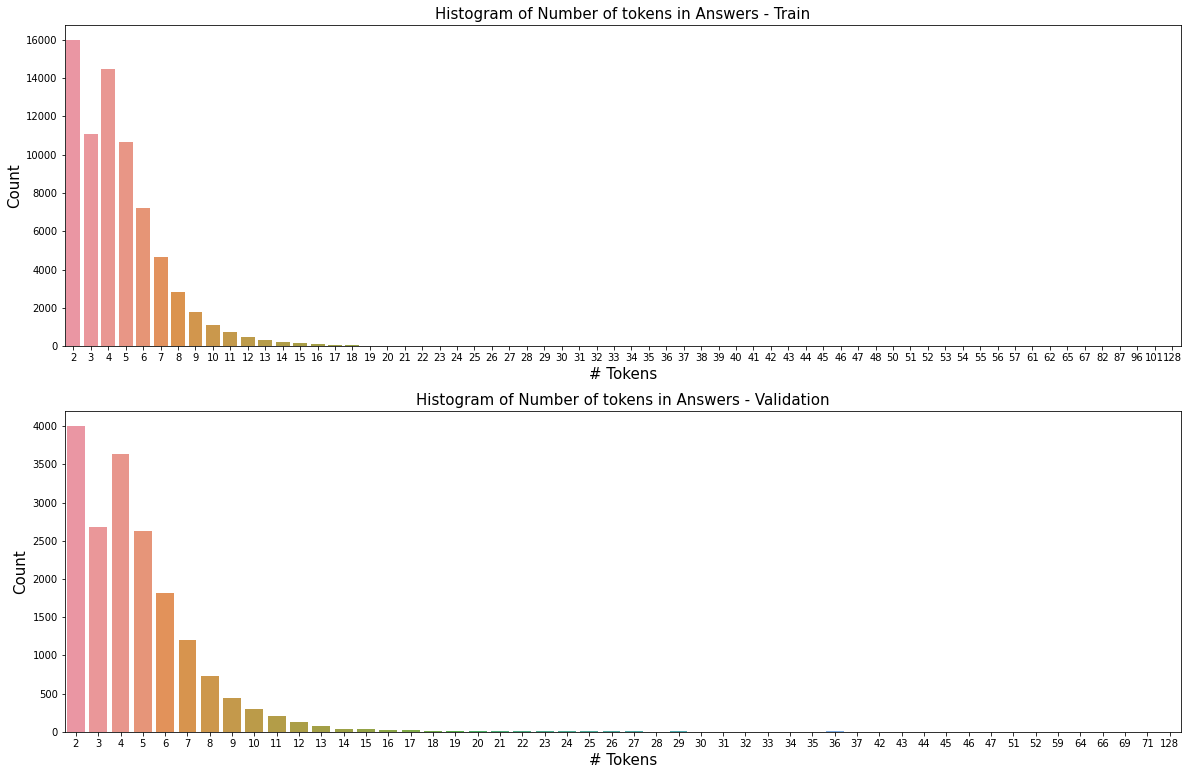

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

len_tok_ans_train = [(tokenized_datasets["train"][i]["labels"] != -100).sum().item() for i in range(len(tokenized_datasets["train"]))]
len_tok_ans_val = [(tokenized_datasets["validation"][i]["labels"] != -100).sum().item() for i in range(len(tokenized_datasets["validation"]))]

fig, axs = plt.subplots(2, 1, figsize=(20,13))

sns.countplot(x = len_tok_ans_train, ax = axs[0])
axs[0].set_title("Histogram of Number of tokens in Answers - Train", size = 15)
axs[0].set_xlabel("# Tokens", size = 15)
axs[0].set_ylabel("Count", size = 15)

sns.countplot(x = len_tok_ans_val, ax = axs[1])
axs[1].set_title("Histogram of Number of tokens in Answers - Validation", size = 15)
axs[1].set_xlabel("# Tokens", size = 15)
axs[1].set_ylabel("Count", size = 15)

plt.show()

In [ ]:
print(f"99% of the train answers are shorter than {np.quantile(len_tok_ans_train, .99)} tokens")
print(f"\n99% of the validation answers are shorter than {np.quantile(len_tok_ans_val, .99)} tokens")

99% of the train answers are shorter than 15.0 tokens

99% of the validation answers are shorter than 15.0 tokens


Thus, it is reasonable to set the `max_length` of the generated text to 15. 

Let's create the `DataLoaders` for training.


In [ ]:
from torch.utils.data import DataLoader 
batch_size = 16

train_dataloader = DataLoader(tokenized_datasets['train'], 
                              shuffle=True, 
                              batch_size=batch_size)

val_dataloader = DataLoader(tokenized_datasets['validation'], 
                            batch_size=batch_size)

test_dataloader = DataLoader(tokenized_datasets["test"], 
                             batch_size = batch_size)

## Baseline Evaluation

### T5-small

Here we evaluate the T5 model on the Validation Dataset, to see the baseline performance of the model.

In [ ]:
# evaluate (batch generation)
base_model.eval()
print('\nEVALUATING...')
val_f1 = []
val_em = []
for eval_batch in tqdm(val_dataloader):

    outputs = base_model.generate(eval_batch["input_ids"].to(device), 
                             attention_mask = eval_batch["attention_mask"].to(device), 
                             max_length=15)
    # compute metrics
    f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
    val_f1.append(f1)
    val_em.append(em)

print("\nVal F1:", np.mean(val_f1))
print("Val EM:", np.mean(val_em))


EVALUATING...


100%|██████████| 1131/1131 [04:54<00:00,  3.83it/s]


Val F1: 0.6611463522954307
Val EM: 0.5703249336870027


### T5-small fine-tuned on SQuAD

Here we evaluate the T5 model fine-tuned on Squad on the Validation Dataset, to see the baseline performance of the model.

In [ ]:
# evaluate (batch generation)
model.eval()
print('\nEVALUATING...')
val_f1 = []
val_em = []
for eval_batch in tqdm(val_dataloader):

    outputs = model.generate(eval_batch["input_ids"].to(device), 
                             attention_mask = eval_batch["attention_mask"].to(device), 
                             max_length=15)
    # compute metrics
    f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
    val_f1.append(f1)
    val_em.append(em)

print("\nVal F1:", np.mean(val_f1))
print("Val EM:", np.mean(val_em))


EVALUATING...


100%|██████████| 1131/1131 [04:41<00:00,  4.02it/s]


Val F1: 0.55014211280932
Val EM: 0.4806255526083112


We can see that the model not trained on SQuAD performs better on HotPotQA. We can explain this behaviour by noticing that it is possible that the model trained on SQuAD has learned that the answer is always contained in the context, which is not the case for HotPotQA. As a consequence, the model not trained on SQuAD is more capable of generalizing to this use-case.

Nonetheless, we still believe that, if fine-tuned on HotPotQA, the model already trained on SQuAD will perform better because has stronger one-hop QA skills. 

## Fine-tune model T5-small

Here it is the training loop.

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm

epochs = 3

optimizer = torch.optim.AdamW(base_model.parameters(), lr=5e-5)

for epoch in range(epochs):  # loop over the dataset multiple times
   print(f"------------ EPOCH:{epoch+1} ------------")
   # train + evaluate on training data
   val_f1 = 0.0
   losses = []
   for i,batch in enumerate(tqdm(train_dataloader)):
      base_model.train()
      # get the inputs;
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = base_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      losses.append(loss.item())

      print("\rLoss:", np.mean(losses), end='')
      loss.backward()
      optimizer.step()

   # evaluate (batch generation)
   base_model.eval()
   print('\nEVALUATING...')
   val_f1 = []
   for eval_batch in tqdm(val_dataloader):
       outputs = base_model.generate(eval_batch["input_ids"].to(device), 
                                max_length = 15)
       # compute metrics
       metrics = compute_metrics(pred_ids=outputs, labels_ids=eval_batch["labels"])
       val_f1.append(metrics)
  
   print("Val F1:", np.mean(val_f1))

------------ EPOCH:1 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.3967917531371209
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8357922218297366
------------ EPOCH:2 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.30070437864292937
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8458908385433537
------------ EPOCH:3 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.2630796758886402
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8577772434700729


### Pushing the model to the hub

Let's save the model in out HF repo `nlpproject2023`. 

In [ ]:
from huggingface_hub import create_repo, delete_repo, HfApi

repo_name = "nlpproject2023/T5-small_HotPotQA_reader"

# creating the repository in the hub 
create_repo(repo_name, repo_type='model', private= False)

# saving the model locally
model.save_pretrained('model')
tokenizer.save_pretrained('model')

# calling the HuggingFace API
api = HfApi()

# uploading the folder
api.upload_folder(
    folder_path="model",
    repo_type="model",
    repo_id=repo_name
)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

'https://huggingface.co/nlpproject2023/T5-small_HotPotQA_reader/tree/main/'

## Fine-tune model trained on SQuAD

Here it is the training loop.

In [ ]:
import torch
import numpy as np
from tqdm.notebook import tqdm

epochs = 3

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(epochs):  # loop over the dataset multiple times
   print(f"------------ EPOCH:{epoch+1} ------------")
   # train + evaluate on training data
   val_f1 = 0.0
   losses = []
   for i,batch in enumerate(tqdm(train_dataloader)):
      model.train()
      # get the inputs;
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      loss = outputs.loss
      losses.append(loss.item())

      print("\rLoss:", np.mean(losses), end='')
      loss.backward()
      optimizer.step()

   # evaluate (batch generation)
   model.eval()
   print('\nEVALUATING...')
   val_f1 = []
   for eval_batch in tqdm(val_dataloader):
       outputs = model.generate(eval_batch["input_ids"].to(device), 
                                max_length = 15)
       # compute metrics
       metrics = compute_metrics(pred_ids=outputs, labels_ids=eval_batch["labels"])
       val_f1.append(metrics)
  
   print("Val F1:", np.mean(val_f1))

------------ EPOCH:1 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.3681658144755234
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8413342958087884
------------ EPOCH:2 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.2853367523970276
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8525843964584184
------------ EPOCH:3 ------------


  0%|          | 0/4522 [00:00<?, ?it/s]

Loss: 0.2517267470979179
EVALUATING...


  0%|          | 0/1131 [00:00<?, ?it/s]

Val F1: 0.8618128538168889


### Pushing the model to the hub

Let's save the model in out HF repo `nlpproject2023`. 

In [ ]:
from huggingface_hub import create_repo, delete_repo, HfApi

repo_name = "nlpproject2023/T5-small_SQuAD_HotPotQA_reader"

# creating the repository in the hub 
create_repo(repo_name, repo_type='model', private= False)

# saving the model locally
model.save_pretrained('model')
tokenizer.save_pretrained('model')

# calling the HuggingFace API
api = HfApi()

# uploading the folder
api.upload_folder(
    folder_path="model",
    repo_type="model",
    repo_id=repo_name
)

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

'https://huggingface.co/nlpproject2023/T5_HotPotQA_reader/tree/main/'

## Train on SQuAD or not? - Evaluation

Let's evaluate the two models fine-tuned on HotPotQA to understand if our intuition was correct. 

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "nlpproject2023/T5-small_HotPotQA_reader"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
val_f1 = []
val_em = []
for eval_batch in tqdm(val_dataloader):
    outputs = model.generate(eval_batch["input_ids"].to(device),
                            attention_mask = eval_batch["attention_mask"].to(device),
                            max_length = 15)
    # compute metrics
    f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
    val_f1.append(f1)
    val_em.append(em)

print("\n##### VALIDATION #####")
print(f"F1: {np.mean(val_f1)}")
print(f"EM: {np.mean(val_em)}")

100%|██████████| 1131/1131 [04:46<00:00,  3.95it/s]


##### VALIDATION #####
F1: 0.8577772434700729
EM: 0.7950817860300619


In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "nlpproject2023/T5-small_SQuAD_HotPotQA_reader"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
val_f1 = []
val_em = []
for eval_batch in tqdm(val_dataloader):
    outputs = model.generate(eval_batch["input_ids"].to(device),
                             attention_mask = eval_batch["attention_mask"].to(device),
                             max_length = 15)
    # compute metrics
    f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
    val_f1.append(f1)
    val_em.append(em)

print("\n##### VALIDATION #####")
print(f"F1: {np.mean(val_f1)}")
print(f"EM: {np.mean(val_em)}")

100%|██████████| 1131/1131 [04:41<00:00,  4.02it/s]


##### VALIDATION #####
F1: 0.8618128538168889
EM: 0.797502210433245


Even if of a small amount, it seems that the model trained on SQuAD performs better after fine-tuning. 

## Hyper-Parameter Tuning

Download the model from the hub

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "nlpproject2023/T5-small_SQuAD_HotPotQA_reader"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

We are going to fine tune some hyper parameters that define the decoding strategy for the model generation. 
We have divided the research between two cases: allowing and not allowing sampling.


In particular, when not allowing sampling we are going to change the value of `num_beams` between 3, 5, 10 and 30, while when allowing sampling, we are going to look for different performance when changing:

* `num_beams`: 3, 10 or 20;
* `top_k`: 10 or 30;

We are going to run the hyper-parameter search on a smaller subset of the validation set due to speed up the computations. 

In [ ]:
# Let's extract radnomly a subset of 2000 samples from the validation set

indexes = random.sample(range(len(datasets["validation"])), 2000)
small_val = datasets["validation"].select(indexes)

tok_small_val = small_val.map(prepare_features, 
                              batched=True, 
                              remove_columns=datasets['validation'].column_names)

tok_small_val.set_format(
    type="torch", columns=["input_ids", "attention_mask", "labels"],
)

batch_size = 8
small_val_dataloader = DataLoader(tok_small_val,
                            batch_size = batch_size)

  0%|          | 0/2 [00:00<?, ?ba/s]

Greedy Evaluation. 

In [ ]:
comp_list = []
columns = ["num_beams", "f1"]

for num_beams in [3, 5, 10, 30]:

      val_f1 = []
      for eval_batch in tqdm(small_val_dataloader):
          outputs = model.generate(
                                   eval_batch["input_ids"].to(device),
                                   attention_mask = eval_batch["attention_mask"].to(device),
                                   num_beams = num_beams,
                                   do_sample = False,
                                   max_length = 15
                                  )
          # compute metrics
          metrics = compute_metrics(pred_ids=outputs, labels_ids=eval_batch["labels"])
          val_f1.append(metrics)
      comp_list.append([num_beams, np.mean(val_f1)])

greedy_results = pd.DataFrame(comp_list, columns = columns)
display(greedy_results)

100%|██████████| 250/250 [07:37<00:00,  1.83s/it]


,num_beams,f1
0,3,0.861660
1,5,0.860694
2,10,0.860875
3,30,0.860875


In [ ]:
best_f1 = greedy_results["f1"].max()
best_num_beams = greedy_results[greedy_results["f1"] == best_f1]["num_beams"].item()

print(f"Best f1: {best_f1}\nnum_beams: {best_num_beams}")

Best f1: 0.8616598229124763
num_beams: 3


Sampling Evaluation

In [ ]:
model.eval()

comp_list = []
columns = ["num_beams", "top_k", "f1"]

for num_beams in [3, 10, 20]:
  for top_k in [10, 30]:

      val_f1 = []
      for eval_batch in tqdm(small_val_dataloader):

          outputs = model.generate(eval_batch["input_ids"].to(device),
                                   attention_mask = eval_batch["attention_mask"].to(device),
                                   num_beams = num_beams,
                                   top_k = top_k,
                                   do_sample = True,
                                   max_length = 15
                                  )
          # compute metrics
          metrics = compute_metrics(pred_ids=outputs, labels_ids=eval_batch["labels"])
          val_f1.append(metrics)
      comp_list.append([num_beams, top_k, np.mean(val_f1)])

sampling_results = pd.DataFrame(comp_list, columns = columns)
display(sampling_results)

100%|██████████| 250/250 [03:42<00:00,  1.12it/s]


,num_beams,top_k,f1
0,3,10,0.864610
1,3,30,0.863713
2,10,10,0.864505
3,10,30,0.863870
4,20,10,0.864263
5,20,30,0.864107


In [ ]:
best_f1 = sampling_results["f1"].max()
best_num_beams = sampling_results[sampling_results["f1"] == best_f1]["num_beams"].item()
best_top_k = sampling_results[sampling_results["f1"] == best_f1]["top_k"].item()

print(f"Best f1: {best_f1}\nnum_beams: {best_num_beams}\ntop_k: {best_top_k}")

Best f1: 0.8646102124183006
num_beams: 3
top_k: 10


Even if with small variations, the best performance is obtained with the sampling method, 3 number of beams and 10 of top_k. 

## Evaluation

In this section we are going to evaluate the model in the test and validation sets, dividing the evaluation between type of question and level of difficulty. 

Let's first download the model. 

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_name = "nlpproject2023/T5-small_SQuAD_HotPotQA_reader"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

### On validation

Let's see how the model performs on validation data. We are going to split the data according to level of difficulty: easy, medium, and hard, and according to type of question: bridge and comparison. 

In [ ]:
batch_size = 8

comp_list = []
columns = ["level", "type", "size", "f1", "em"]

for level in ["easy", "medium", "hard"]:
  for q_type in ["bridge", "comparison"]: 
    
    print(f"\nEvaluating {level} - {q_type}")
    # Prepare Data for evaluation
    cur_df = val_df[(val_df["level"] == level) & (val_df["type"] == q_type)]
    cur_ds = Dataset.from_dict(cur_df)
    tok_ds = cur_ds.map(
        prepare_features, batched=True, remove_columns=cur_ds.column_names
    )
    tok_ds.set_format(
        type="torch", columns=["input_ids", "attention_mask", "labels"],
    )

    val_dataloader = DataLoader(tok_ds, 
                                batch_size=batch_size)
    

    # Evaluating

    val_f1 = []
    val_em = []
    for eval_batch in tqdm(val_dataloader):
        outputs = model.generate(eval_batch["input_ids"].to(device),
                                attention_mask = eval_batch["attention_mask"].to(device),
                                num_beams = 3,
                                top_k = 10,
                                do_sample = True,
                                max_length = 15)
        # compute metrics
        f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
        val_f1.append(f1)
        val_em.append(em)

    comp_list.append([level, q_type, len(cur_df), np.mean(val_f1), np.mean(val_em)])

results = pd.DataFrame(comp_list, columns = columns)


Evaluating easy - bridge


  0%|          | 0/3 [00:00<?, ?ba/s]

100%|██████████| 359/359 [01:25<00:00,  4.19it/s]


Evaluating easy - comparison


  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 91/91 [00:19<00:00,  4.66it/s]


Evaluating medium - bridge


  0%|          | 0/10 [00:00<?, ?ba/s]

100%|██████████| 1157/1157 [04:20<00:00,  4.44it/s]


Evaluating medium - comparison


  0%|          | 0/3 [00:00<?, ?ba/s]

100%|██████████| 265/265 [00:58<00:00,  4.57it/s]


Evaluating hard - bridge


  0%|          | 0/3 [00:00<?, ?ba/s]

100%|██████████| 310/310 [01:15<00:00,  4.08it/s]


Evaluating hard - comparison


  0%|          | 0/1 [00:00<?, ?ba/s]

100%|██████████| 80/80 [00:18<00:00,  4.42it/s]


In [ ]:
results

,level,type,size,f1,em
0,easy,bridge,2869,0.855518,0.758287
1,easy,comparison,723,0.783884,0.715659
2,medium,bridge,9256,0.930154,0.889909
3,medium,comparison,2120,0.789954,0.772642
4,hard,bridge,2477,0.765304,0.609435
5,hard,comparison,640,0.620101,0.553125


In [ ]:
for level in ["easy", "medium", "hard"]:

  sub_res = results[results["level"] == level]
  print(f"##### {level.upper()} #####")
  f1 = (sub_res["f1"] * sub_res["size"]).sum() / sub_res["size"].sum()
  em = (sub_res["em"] * sub_res["size"]).sum() / sub_res["size"].sum()
  print(f"F1: {f1}")
  print(f"EM: {em}")
  
for q_type in ["bridge", "comparison"]:

  sub_res = results[results["type"] == q_type]
  print(f"##### {q_type.upper()} #####")
  f1 = (sub_res["f1"] * sub_res["size"]).sum() / sub_res["size"].sum()
  em = (sub_res["em"] * sub_res["size"]).sum() / sub_res["size"].sum()
  print(f"F1: {f1}")
  print(f"EM: {em}")

f1 = (results["f1"] * results["size"]).sum() / results["size"].sum()
em = (results["em"] * results["size"]).sum() / results["size"].sum()

print("\n\n##### TOTAL VALIDATION #####")
print(f"F1: {f1}")
print(f"EM: {em}")

##### EASY #####
F1: 0.8410990692642885
EM: 0.7497068047250751
##### MEDIUM #####
F1: 0.9040271360799097
EM: 0.8680555555555556
##### HARD #####
F1: 0.7354899185997278
EM: 0.5978734980905959
##### BRIDGE #####
F1: 0.8875254686068761
EM: 0.8164701296277328
##### COMPARISON #####
F1: 0.7574837038530361
EM: 0.7204770896631363


##### TOTAL VALIDATION #####
F1: 0.8624806543056527
EM: 0.7979827777783166


### On test

Let's see how our model perform in the test set. I am going to split the test set by type of question: bridge or comparison.

In [ ]:
batch_size = 8

comp_list = []
columns = ["type", "size", "f1", "em"]
level = "hard"
for q_type in ["bridge", "comparison"]: 
  
  print(f"\nEvaluating {level} - {q_type}")
  # Prepare Data for evaluation
  cur_df = test_df[test_df["type"] == q_type]
  cur_ds = Dataset.from_dict(cur_df)
  tok_ds = cur_ds.map(
      prepare_features, batched=True, remove_columns=cur_ds.column_names
  )
  tok_ds.set_format(
      type="torch", columns=["input_ids", "attention_mask", "labels"],
  )

  test_dataloader = DataLoader(tok_ds, 
                              batch_size=batch_size)
  

  # Evaluating

  test_f1 = []
  test_em = []
  for eval_batch in tqdm(test_dataloader):
      outputs = model.generate(eval_batch["input_ids"].to(device),
                              attention_mask = eval_batch["attention_mask"].to(device),
                              num_beams = 3,
                              top_k = 10,
                              do_sample = True,
                              max_length = 15)
      # compute metrics
      f1, em = compute_metrics_eval(pred_ids=outputs, labels_ids=eval_batch["labels"])
      test_f1.append(f1)
      test_em.append(em)

  comp_list.append([q_type, len(cur_df), np.mean(test_f1), np.mean(test_em)])

results = pd.DataFrame(comp_list, columns = columns)


Evaluating hard - bridge


  0%|          | 0/6 [00:00<?, ?ba/s]

100%|██████████| 740/740 [03:00<00:00,  4.09it/s]



Evaluating hard - comparison


  0%|          | 0/2 [00:00<?, ?ba/s]

100%|██████████| 186/186 [00:42<00:00,  4.34it/s]


In [ ]:
results

,type,size,f1,em
0,bridge,5917,0.769669,0.612399
1,comparison,1487,0.619063,0.558276


In [ ]:
for q_type in ["bridge", "comparison"]:

  sub_res = results[results["type"] == q_type]
  print(f"##### {q_type.upper()} #####")
  f1 = (sub_res["f1"] * sub_res["size"]).sum() / sub_res["size"].sum()
  em = (sub_res["em"] * sub_res["size"]).sum() / sub_res["size"].sum()
  print(f"F1: {f1}")
  print(f"EM: {em}")


f1 = (results["f1"] * results["size"]).sum() / results["size"].sum()
em = (results["em"] * results["size"]).sum() / results["size"].sum()

print("\n\n##### TOTAL TEST #####")
print(f"F1: {f1}")
print(f"EM: {em}")

##### BRIDGE #####
F1: 0.7696686661549867
EM: 0.6123986486486487
##### COMPARISON #####
F1: 0.6190630054626056
EM: 0.5582757296466975


##### TOTAL TEST #####
F1: 0.7394214190656335
EM: 0.6015287431170575


## Play

Here i define a function to simply compute some outputs. 

In [ ]:
def qa(question, context):
  input = f"question: {question} context: {context}"
  encoding = tokenizer(input, return_tensors='pt').to(device)

  output = model.generate(**encoding, 
                          do_sample = True, 
                          num_beams = 3,
                          top_k = 10,
                          max_length = 15) 

  answer = tokenizer.decode(output[0], skip_special_tokens = True) 
  return answer

In [ ]:
idx = np.random.randint(len(val_df))

row = val_df.iloc[idx]  
question = row["question"] 
context = row["context"] 
gold_answer = row["answer"]
q_type = row["type"]
predicted_answer = qa(question, context)

f1 = f1_score(predicted_answer, gold_answer)

print(f"""
Type: {q_type}
Question: {question} 
Context: {context} 
Predicted answer: {predicted_answer}
Gold answer: {gold_answer}
F1: {f1}""")


Type: comparison
Question: What occupations do Toshi and Emily Haines share? 
Context: Toshimitsu Deyama (出山利三 , Deyama Toshimitsu , born October 10, 1965 in Tateyama, Chiba) , known exclusively by his stage name Toshi, is a Japanese singer and songwriter. Emily Haines (born January 25, 1974) is a Canadian singer and songwriter. 
Predicted answer: singer and songwriter
Gold answer: singer and songwriter
F1: (1.0, 1.0, 1.0)
